<a href="https://colab.research.google.com/github/JoannaAndrews/-JoannaAndrews-.github.io/blob/main/Final_Copy_of_Brain_Tumor_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount = True)


Mounted at /content/gdrive/


In [ ]:
%cd /content/gdrive/MyDrive/Joanna Andrews

/content/gdrive/.shortcut-targets-by-id/15T3F0w-3J3Zbx7DyZIZK0HZ2qO0BK-Qh/Joanna Andrews


##Preprocessing

In [ ]:
def normalize_image(image):
  range = np.max(image[:][:]) - np.min(image[:][:])
  min = np.min(image[:][:])
  return (image - min) / range

In [ ]:

data_gen = ImageDataGenerator(preprocessing_function= normalize_image) 
train_generator = data_gen.flow_from_directory("Training", batch_size=100, classes = ["glioma", "meningioma","pituitary", "notumor"]) 
val_generator = data_gen.flow_from_directory("Testing", batch_size = 100, classes = ["glioma", "meningioma","pituitary", "notumor"])


Found 5718 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
for image_data, labels_data in train_generator:
  image_data = np.mean(image_data, axis = 3)
  image_data = np.reshape(image_data, [image_data.shape[0], image_data.shape[1] * image_data.shape[2]])
  labels_data_categorical = np.argwhere(labels_data)[:,1]
  #labels_data = labels_data[:,3] -> binomial classification
  break


for val_image_data, val_labels_data in val_generator:
  val_image_data = np.mean(val_image_data, axis = 3)
  val_image_data = np.reshape(val_image_data, [val_image_data.shape[0], val_image_data.shape[1] * val_image_data.shape[2]])
  val_labels_data_categorical = np.argwhere(val_labels_data)[:,1]
  #val_labels_data = val_labels_data[:,3]
  break


In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
image_data_s = ss.fit_transform(image_data)

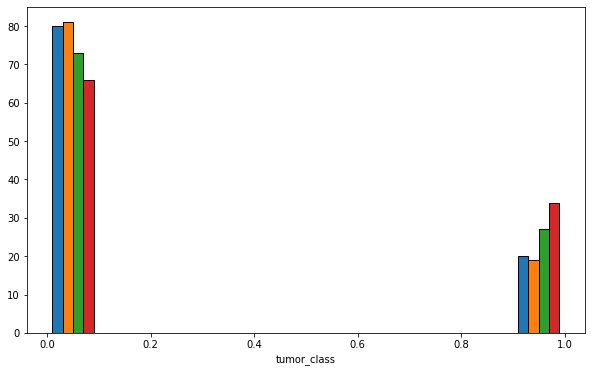

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(labels_data, edgecolor = 'black')
plt.xlabel('tumor_class')
plt.show()

In [ ]:
scores = {}

# Evaluation Metrics: Confusion Matrix

In [ ]:
import seaborn as sns 

def confusion_matrix(predictions, validation_data):
  cm = np.zeros((4,4))
  for i in range(4):
    for j in range(4):
      cm[i,j] = np.sum( (validation_data == i) * (predictions == j)) 
 
  s = sns.heatmap(cm, annot = True, xticklabels = ["glioma", "meningioma","pituitary", "notumor"], yticklabels = ["glioma", "meningioma","pituitary", "notumor"])
  s.set(xlabel='Predicted', ylabel='True')

#Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
#multi_class =  "ovr"
logistic_model = LogisticRegression(C=3)
logistic_model.fit(image_data, labels_data_categorical)
log_predictions = logistic_model.predict(val_image_data)

from sklearn.metrics import accuracy_score
log_accuracy = accuracy_score(log_predictions, val_labels_data_categorical)
print(log_accuracy)

0.58


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


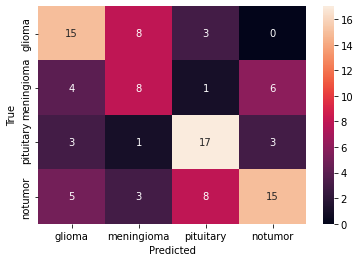

In [ ]:
confusion_matrix(log_predictions, val_labels_data_categorical)

In [ ]:
lr_params = {
    'C' : np.arange(1,6),
    'penalty': ['l2']
}
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator = LogisticRegression(), param_grid = lr_params, scoring = 'accuracy')
grid.fit(image_data_s, labels_data_categorical)

print(grid.best_params_)
print(grid.best_score_)

scores['lr'] = grid.best_score_

#SVM Classifier

In [ ]:

from sklearn.metrics import accuracy_score

from sklearn.svm import SVC
svm_model = SVC(C=1, kernel = 'linear')
svm_model.fit(image_data, labels_data_categorical)
svm_predictions = svm_model.predict(val_image_data)
svm_accuracy = accuracy_score(svm_predictions, val_labels_data_categorical)
print(svm_accuracy)

In [ ]:
confusion_matrix(svm_predictions, val_labels_data_categorical)

In [ ]:
svm_params = {
    'kernel': ['linear', 'rbf'],
    'C': np.arange(1,10)
}

grid = GridSearchCV(estimator = SVC(), param_grid = svm_params, scoring= 'accuracy')
grid.fit(image_data, labels_data_categorical)

print(grid.best_params_)
print(grid.best_score_)

scores['svc'] = grid.best_score_

{'C': 1, 'kernel': 'linear'}
0.72


# KNN Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
kn_model = KNeighborsClassifier(n_neighbors=1)
kn_model.fit(image_data, labels_data_categorical)
kn_predictions = kn_model.predict(val_image_data)
kn_acc= accuracy_score(kn_predictions, val_labels_data_categorical)
print(kn_acc)

0.56


In [ ]:
from sklearn.model_selection import GridSearchCV
k_params = { 
    'n_neighbors' : np.linspace(1, 10, 10).astype(int)
}

grid = GridSearchCV(estimator = KNeighborsClassifier(), param_grid = k_params, scoring = 'accuracy')
grid.fit(image_data, labels_data_categorical)

print(grid.best_params_)
print(grid.best_score_)

scores['knn'] = grid.best_score_

{'n_neighbors': 1}
0.65


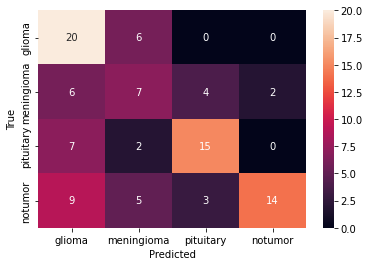

In [ ]:
confusion_matrix(kn_predictions, val_labels_data_categorical)

#Gradient Boosting Classifier

In [ ]:

from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
gb_model = GradientBoostingClassifier(loss ='deviance', n_estimators= 20, random_state= 3)
gb_model.fit(image_data, labels_data_categorical)
gb_predictions = gb_model.predict(val_image_data)
gb_acc = accuracy_score(gb_predictions, val_labels_data_categorical)
print(gb_acc)

0.64


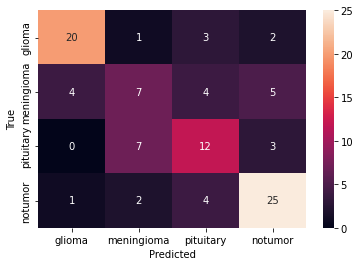

In [ ]:
confusion_matrix(gb_predictions, val_labels_data_categorical)

In [ ]:
from sklearn.model_selection import GridSearchCV
gb_params = {
    'random_state' : np.arange(1,7, 2),
    #'learning_rate': np.linspace(0,1,10),
    'loss': ['deviance'],
    #'max_depth': np.arange(1,10),
    'n_estimators': np.arange(10,30, 10)
}

grid = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid = gb_params, scoring = 'accuracy')
grid.fit(image_data, labels_data_categorical)

print(grid.best_params_)
print(grid.best_score_)

scores['gb'] = grid.best_score_

{'loss': 'deviance', 'n_estimators': 20, 'random_state': 3}
0.71


In [ ]:
np.arange(1,7, 2)

array([1, 3, 5])

# Decision Tree Classifier

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
dt_model = DecisionTreeClassifier(criterion=  'entropy', max_depth = 4, splitter = 'best')
dt_model.fit(image_data, labels_data_categorical)
dt_predictions = dt_model.predict(val_image_data)
dt_acc = accuracy_score(dt_predictions, val_labels_data_categorical)

In [ ]:
dt_params = {
    'criterion' : ['entropy', 'gini'],
    'splitter' : ['best', 'random'],
    'max_depth' : np.arange(2,8,2)
    
}

from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid = dt_params, scoring = 'accuracy')
grid.fit(image_data, labels_data_categorical)

print(grid.best_params_)
print(grid.best_score_)
scores['dt'] = grid.best_score_

{'criterion': 'entropy', 'max_depth': 4, 'splitter': 'best'}
0.65


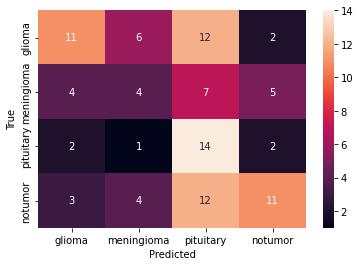

In [ ]:
confusion_matrix(dt_predictions, val_labels_data_categorical)

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(random_state=20, criterion = 'gini', max_depth = 2.0, n_estimators = 90)
rf_model.fit(image_data, labels_data_categorical)
rf_predictions = rf_model.predict(val_image_data)
rf_acc =  accuracy_score(rf_predictions, val_labels_data_categorical)

In [ ]:
rf_params = {
    'n_estimators': np.arange(10,130,10),
    'criterion': ['gini', 'entropy'],
    'max_depth': np.linspace(1,5,5)

}

grid = GridSearchCV(estimator = RandomForestClassifier(), param_grid = rf_params, scoring = 'accuracy')
grid.fit(image_data, labels_data_categorical)

print(grid.best_params_)
print(grid.best_score_)
scores['rf'] = grid.best_score_

{'criterion': 'gini', 'max_depth': 2.0, 'n_estimators': 90}
0.7699999999999999


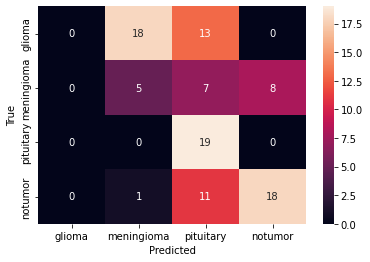

In [ ]:
confusion_matrix(rf_predictions, val_labels_data_categorical)

# Ridge Classifier

In [ ]:
from sklearn.linear_model import RidgeClassifier
rd_model = RidgeClassifier(alpha = 0)
rd_model.fit(image_data,labels_data_categorical)
rd_predictions = rd_model.predict(val_image_data)
#rd_acc = accuracy_score(rd_predictions, val_labels_data_categorical)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:197: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  "Singular matrix in solving dual problem. Using "


In [ ]:
rd_params = {
    'alpha' : np.linspace(0,1,5) #5 values, 4 spaces btw values  --> difference of 1 divided among 4 spaces --> incremental increase of .25,

}

grid = GridSearchCV(estimator = RidgeClassifier(), param_grid = rd_params, scoring = 'accuracy')
grid.fit(image_data, labels_data_categorical)

print(grid.best_params_)
print(grid.best_score_)
scores['ridge'] = grid.best_score_

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.19953e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.7046e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.26734e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.14207e-09): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning:

{'alpha': 0.0}
0.6699999999999999


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.47465e-10): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)


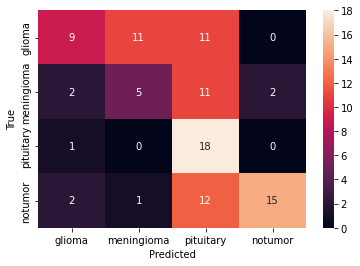

In [ ]:
confusion_matrix(rd_predictions, val_labels_data_categorical)

# Comparing Accuracies of Baseline Models

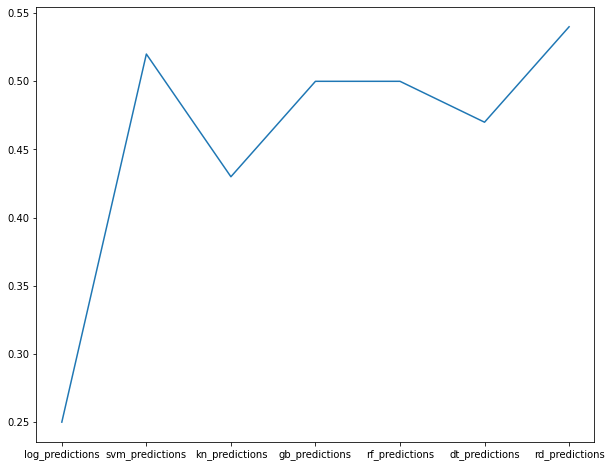

In [ ]:
accuracies = []
predictions = [log_predictions, svm_predictions, kn_predictions, gb_predictions, rf_predictions, dt_predictions, rd_predictions]
text_predictions = ['log_predictions', 'svm_predictions', 'kn_predictions', 'gb_predictions', 'rf_predictions', 'dt_predictions', 'rd_predictions']

for prediction in predictions:
  accuracies.append(accuracy_score(prediction, val_labels_data_categorical))
#accuracies = np.array([accuracies])

figure = plt.figure(figsize=(10,8))
ax = plt.axes()
ax.plot(text_predictions, accuracies)

In [ ]:
#plt.hist(accuracies)

plt.figure(figsize=(10,6))
plt.hist(accuracies, edgecolor = 'black')
plt.xlabel(text_predictions)
plt.show()

#CNN Model

In [ ]:

from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
import os
import tensorflow

checkpoint_path = "/content/gdrive/MyDrive/Joanna Andrews/Model_Checkpoints/Checkpoint.kpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


model = Sequential()
#model.add(Reshape((256,256,1)))
model.add(Conv2D(32, (3,3), padding = 'same', activation = 'relu', input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size = (2,2)))
#model.add(Conv2D(64, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Conv2D(128, (3,3), padding = 'same', activation = 'relu'))


model.add(Conv2D(256, (3,3), padding = 'same', activation = 'relu'))
#model.add(Conv2D(256, (3,3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Flatten())
model.add(Dense(units = 4, activation = 'sigmoid'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       36992     
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 256)      0

In [ ]:
model.fit(x=train_generator, epochs = 20,  validation_data = val_generator,  callbacks=[cp_callback], shuffle = True)  # 5 epochs: val_accuracy = .9115

Epoch 1/20
58/58 [==============================] - ETA: 0s - loss: 0.8203 - accuracy: 0.6910 
Epoch 1: saving model to /content/gdrive/MyDrive/Joanna Andrews/Model_Checkpoints/Checkpoint.kpt
58/58 [==============================] - 1794s 31s/step - loss: 0.8203 - accuracy: 0.6910 - val_loss: 0.5977 - val_accuracy: 0.8093
Epoch 2/20
58/58 [==============================] - ETA: 0s - loss: 0.3223 - accuracy: 0.8891
Epoch 2: saving model to /content/gdrive/MyDrive/Joanna Andrews/Model_Checkpoints/Checkpoint.kpt
58/58 [==============================] - 33s 560ms/step - loss: 0.3223 - accuracy: 0.8891 - val_loss: 0.2897 - val_accuracy: 0.8955
Epoch 3/20
58/58 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9274
Epoch 3: saving model to /content/gdrive/MyDrive/Joanna Andrews/Model_Checkpoints/Checkpoint.kpt
58/58 [==============================] - 34s 591ms/step - loss: 0.1963 - accuracy: 0.9274 - val_loss: 0.2659 - val_accuracy: 0.9130
Epoch 4/20
58/58 [============

(1, 256, 256, 3) (100, 256, 256, 3)
(1, 4) (1,)
(1,)
loss:  tf.Tensor(0.9998448, shape=(), dtype=float32)
(1, 256, 256, 3)


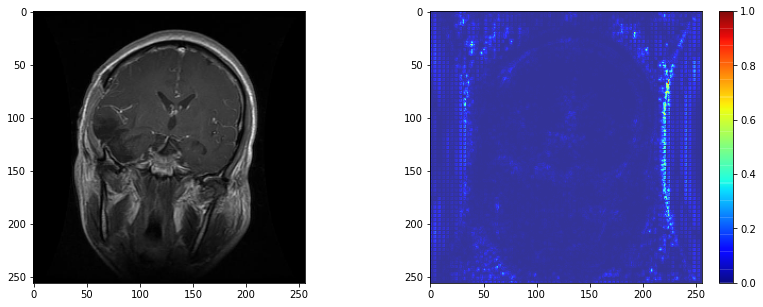

In [ ]:
from keras_preprocessing.image import image_data_generator
import tensorflow as tf

for images_data, labels in train_generator:
  break
#y_pred = model.predict(tf.expand_dims(images_data[0], axis=0))

images = tf.Variable(tf.expand_dims(images_data[0], axis=0), dtype=float)
print(images.shape, images_data.shape)
with tf.GradientTape() as tape:
    pred = model(images, training=False)
    pred_class = tf.math.argmax(pred, axis=1)
    print(pred.shape, pred_class.shape)
    #class_idxs_sorted = np.argsort(pred_class.numpy().flatten())[::-1]
    print(pred_class.shape)
    #print(class_idxs_sorted.shape)
    loss = pred[0,pred_class[0]]
    #loss = pred_class[class_idxs_sorted]
    print("loss: ", loss)

print(images.shape)
grads = tape.gradient(loss, images)
#print(grads)

dgrad_abs = tf.math.abs(grads)
dgrad_max_ = np.max(dgrad_abs, axis=3)[0]

## normalize to range between 0 and 1
arr_min, arr_max  = np.min(dgrad_max_), np.max(dgrad_max_)
grad_eval = (dgrad_max_ - arr_min) / (arr_max - arr_min + 1e-18)

fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(images[0])
i = axes[1].imshow(grad_eval,cmap="jet",alpha=0.8)
fig.colorbar(i)

In [ ]:

print(image_data.shape)
print(labels_data.shape)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape

from tensorflow.keras.applications import VGG16
#from keras.models import Sequential
vgg_model = Sequential()
layer = VGG16(include_top=False, weights='imagenet', pooling = 'avg', input_shape=(256,256,3))
layer.trainable = False
vgg_model.add(layer)
vgg_model.add(Flatten())
vgg_model.add(Dense(units = 500, activation = 'relu'))
vgg_model.add(Dense(units = 4, activation = 'sigmoid'))
vgg_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

vgg_model.summary()

In [ ]:
image_data.shape

(100, 65536)

In [ ]:
import os
import tensorflow

checkpoint_path = "/content/gdrive/MyDrive/Joanna Andrews/Model_Checkpoints/vgg_Checkpoint.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tensorflow.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



vgg_model.fit(x=train_generator, epochs = 3,  validation_data = val_generator,  callbacks=[cp_callback], shuffle = True)  # 5 epochs: val_accuracy = .9115

In [ ]:

from tensorflow.keras.applications import Xception

X_ception = Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling="max",
    classes=4,
    classifier_activation="softmax",
)

X_ception.summary()

In [ ]:
from tensorflow.keras.applications import VGG19
vgg_19 = Sequential()
vgg_19.add(VGG19(weights = 'imagenet'))
vgg_19.summary()

In [ ]:
def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 1)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()
    

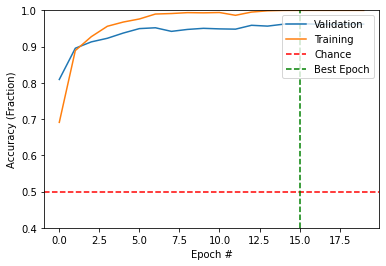

In [ ]:
plot_acc(model.history) 